In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [295]:
dict_tickers = {"360750.KS":"S&P500",  "446720.KS":"미국배당다우존스", "133690.KS":"미국나스닥100",
                "294400.KS":"키움200TR", "195980.KS":"MSCI",
                "272580.KS":"단기채권", "284430.KS":"KODEX미국채혼합", "490490.KS":"미국배당미국채혼합",
                "148070.KS":"한국채10년", "305080.KS":"미국채10년",
                "352560.KS":"US리츠", "411060.KS":"금", "456610.KS":"미국달러SOFR" }

ticker = '411060.KS'
etf = yf.Ticker(ticker)

df = etf.history(period="5y", interval="1d")
#df = df[['Close', 'Volume']]

# 혹시 멀티인덱스면 평탄화
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]


df['MA7'] = df['Close'].rolling(window=7, min_periods=1).mean()
df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()

# -------------------------
# 1) 장단기 스프레드
# -------------------------
df['mv_spread'] = df['MA7'] - df['MA20']
df['mv_diff'] = df['mv_spread'].diff()  # 변화량
df['mv_sign'] = df['mv_spread'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df['mv_sign_change'] = df['mv_sign'].diff()

# mv 기반 raw trend
df['trend'] = np.where(df['mv_sign']==1,'상승',
                 np.where(df['mv_sign']==-1,'하락','flat'))


flat_mask = df['trend']=='flat'

tmp = df['trend'].replace('flat', np.nan)
ff = tmp.ffill()   # forward fill
bf = tmp.bfill()   # backward fill

# ffill 된 row의 index로부터 거리
dist_ff = np.abs(ff.index - df.index).days
dist_bf = np.abs(bf.index - df.index).days

df.loc[flat_mask,'trend'] = np.where(dist_ff < dist_bf, ff, bf)[flat_mask]

# # percentile 기준
# lower_pct = 40  # 하위 40%
# upper_pct = 60  # 상위 60%
#
# lower_thresh = np.percentile(df['mv_spread'], lower_pct)
# upper_thresh = np.percentile(df['mv_spread'], upper_pct)
#
#
#
# df.loc[(df['mv_spread'] < upper_thresh) & (df['mv_spread'] > lower_thresh), 'trend'] = 'flat'



# flat 비율 확인
print(df['trend'].value_counts(normalize=True))




# 3️⃣ 기술지표 계산
df['return'] = df['Close'].pct_change() ## 전일 대비 퍼센트 변화(수익률)

# --- EMA (단기/장기 추세) 단기/장기 비교로 상승/하락 판단
# 이동평균의 한 종류이지만 최근 데이터에 더 가중치를 줌
# EMA7 > EMA20 → 단기 추세가 장기 추세보다 강한 상승 신호
# EMA7 < EMA20 → 단기 추세가 장기보다 낮으면 하락 신호
df['EMA7'] = df['Close'].ewm(span=7, adjust=False).mean()
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()

# --- MACD (추세 전환 신호) EMA차이로 골든/데드 크로스 판단
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# --- Bollinger Bands
# 중간선: 20일 단순이동평균(MA20)
# 상단 밴드: MA20 + 2σ, 하단 밴드: MA20 - 2σ
# 의미: 가격 변동 범위를 시각화, 밴드 밖으로 나가면 과매수/과매도 신호
df['MA20'] = df['Close'].rolling(20).mean()
df['BB_upper'] = df['MA20'] + 2*df['Close'].rolling(20).std()
df['BB_lower'] = df['MA20'] - 2*df['Close'].rolling(20).std()
df['BB_width'] = df['BB_upper'] - df['BB_lower']

# --- ATR (Average True Range) 변동성 지표, 값이 클수록 가격이 급격히 움직임
# True Range(TR) = 하루 변동폭 계산으로 리스크 판단
# high_low : 오늘 고가-저가, high_close : 오늘 고가-어제 종가, low_close : 오늘 저가-어제 종가
# 셋 중 절댓값 최대값 사용
high_low = df['High'] - df['Low']
high_close = np.abs(df['High'] - df['Close'].shift())
low_close = np.abs(df['Low'] - df['Close'].shift())
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['ATR14'] = tr.rolling(14).mean()

# --- Stochastic Oscillator (%K) 과매수/과매도 확인용
# 최근 14일 범위에서 종가 위치를 비율로 계산 → %K
# %D = %K의 3일 이동평균
# 의미: 과매수/과매도 판단
# %K > 0.8 → 과매수
# %K < 0.2 → 과매도
low14 = df['Low'].rolling(14).min()
high14 = df['High'].rolling(14).max()
df['Stoch_K'] = (df['Close'] - low14) / (high14 - low14)
df['Stoch_D'] = df['Stoch_K'].rolling(3).mean()
df = df.dropna()


trend
상승    0.656958
하락    0.343042
Name: proportion, dtype: float64


In [296]:
dict_tickers = {"360750.KS":"S&P500",  "446720.KS":"미국배당다우존스", "133690.KS":"미국나스닥100",
                "294400.KS":"키움200TR", "195980.KS":"MSCI",
                "272580.KS":"단기채권", "284430.KS":"KODEX미국채혼합", "490490.KS":"미국배당미국채혼합",
                "148070.KS":"한국채10년", "305080.KS":"미국채10년",
                "352560.KS":"US리츠", "411060.KS":"금", "456610.KS":"미국달러SOFR" }

ticker = '360750.KS'
etf = yf.Ticker(ticker)

df = etf.history(period="5y", interval="1d")
#df = df[['Close', 'Volume']]

# 혹시 멀티인덱스면 평탄화
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

# 이동평균
df['MA7'] = df['Close'].rolling(7, min_periods=1).mean()
df['MA20'] = df['Close'].rolling(20, min_periods=1).mean()

# mv_spread와 변화량
df['mv_spread'] = df['MA7'] - df['MA20']
df['mv_diff'] = df['mv_spread'].diff()

window = 3  # 최근 3일 평균 변화
df['mv_diff_mean'] = df['mv_spread'].diff().rolling(window).mean()
df['trend'] = np.where(df['mv_diff_mean'] > 0, '상승', '하락')

# # 골든/데드 크로스 탐지
# df['gc'] = (df['MA7'] > df['MA20']) & (df['MA7'].shift(1) <= df['MA20'].shift(1))
# df['dc'] = (df['MA7'] < df['MA20']) & (df['MA7'].shift(1) >= df['MA20'].shift(1))
#
# # flat 기준: cross 시점 주변 window + mv_diff 변화량
# threshold = 0.01
# window = 1  # cross 전후 포함
#
# trend_list = []
# for i in range(len(df)):
#     # cross 근처
#     if df['gc'].iloc[max(0,i-window):i+window+1].any() or df['dc'].iloc[max(0,i-window):i+window+1].any():
#         trend_list.append('flat')
#     else:
#         if df['mv_diff'].iloc[i] > threshold:
#             trend_list.append('상승')
#         elif df['mv_diff'].iloc[i] < -threshold:
#             trend_list.append('하락')
#         else:
#             trend_list.append('flat')
#
# df['trend'] = trend_list

# flat 비율 확인
print(df['trend'].value_counts(normalize=True))




# 3️⃣ 기술지표 계산
df['return'] = df['Close'].pct_change() ## 전일 대비 퍼센트 변화(수익률)

# --- EMA (단기/장기 추세) 단기/장기 비교로 상승/하락 판단
# 이동평균의 한 종류이지만 최근 데이터에 더 가중치를 줌
# EMA7 > EMA20 → 단기 추세가 장기 추세보다 강한 상승 신호
# EMA7 < EMA20 → 단기 추세가 장기보다 낮으면 하락 신호
df['EMA7'] = df['Close'].ewm(span=7, adjust=False).mean()
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()

# --- MACD (추세 전환 신호) EMA차이로 골든/데드 크로스 판단
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# --- Bollinger Bands
# 중간선: 20일 단순이동평균(MA20)
# 상단 밴드: MA20 + 2σ, 하단 밴드: MA20 - 2σ
# 의미: 가격 변동 범위를 시각화, 밴드 밖으로 나가면 과매수/과매도 신호
df['MA20'] = df['Close'].rolling(20).mean()
df['BB_upper'] = df['MA20'] + 2*df['Close'].rolling(20).std()
df['BB_lower'] = df['MA20'] - 2*df['Close'].rolling(20).std()
df['BB_width'] = df['BB_upper'] - df['BB_lower']

# --- ATR (Average True Range) 변동성 지표, 값이 클수록 가격이 급격히 움직임
# True Range(TR) = 하루 변동폭 계산으로 리스크 판단
# high_low : 오늘 고가-저가, high_close : 오늘 고가-어제 종가, low_close : 오늘 저가-어제 종가
# 셋 중 절댓값 최대값 사용
high_low = df['High'] - df['Low']
high_close = np.abs(df['High'] - df['Close'].shift())
low_close = np.abs(df['Low'] - df['Close'].shift())
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['ATR14'] = tr.rolling(14).mean()

# --- Stochastic Oscillator (%K) 과매수/과매도 확인용
# 최근 14일 범위에서 종가 위치를 비율로 계산 → %K
# %D = %K의 3일 이동평균
# 의미: 과매수/과매도 판단
# %K > 0.8 → 과매수
# %K < 0.2 → 과매도
low14 = df['Low'].rolling(14).min()
high14 = df['High'].rolling(14).max()
df['Stoch_K'] = (df['Close'] - low14) / (high14 - low14)
df['Stoch_D'] = df['Stoch_K'].rolling(3).mean()
df = df.dropna()


trend
상승    0.502492
하락    0.497508
Name: proportion, dtype: float64


/var/folders/jk/1j1mgc7x11122bdp64mnjcf40000gp/T/ipykernel_5218/1516034973.py:59: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['return'] = df['Close'].pct_change() ## 전일 대비 퍼센트 변화(수익률)


In [206]:

dict_tickers = {"360750.KS":"S&P500",  "446720.KS":"미국배당다우존스", "133690.KS":"미국나스닥100",
                "294400.KS":"키움200TR", "195980.KS":"MSCI",
                "272580.KS":"단기채권", "284430.KS":"KODEX미국채혼합", "490490.KS":"미국배당미국채혼합",
                "148070.KS":"한국채10년", "305080.KS":"미국채10년",
                "352560.KS":"US리츠", "411060.KS":"금", "456610.KS":"미국달러SOFR" }

ticker = '360750.KS'
etf = yf.Ticker(ticker)

df = etf.history(period="5y", interval="1d")
#df = df[['Close', 'Volume']]

# 혹시 멀티인덱스면 평탄화
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

# 위치 시프트
df['close_shifted'] = df['Close'].shift(1)
df['close_diff'] = df['Close'].diff()

# 4️⃣ RSI 계산 최근 14일(혹은 N일) 동안 상승폭/하락폭 평균 계산
# delta = df['Close'].diff()
up = df['close_diff'].clip(lower=0) ## 상승폭
down = -1 * df['close_diff'].clip(upper=0) ## 하락폭
roll_up = up.rolling(14).mean()
roll_down = down.rolling(14).mean()
RS = roll_up / roll_down
df['RSI'] = 100 - (100 / (1 + RS))

# 이동평균선 생성 7d, 20d, 60d
df['MA7'] = df['Close'].rolling(window=7, min_periods=1).mean()
df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()
df['MA60'] = df['Close'].rolling(window=60, min_periods=1).mean()


# 단-장기 편차 및 변곡점
df['mv_spread'] = df['MA7'] - df['MA20']
df['mv_sign'] = df['mv_spread'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df['mv_sign_change'] = df['mv_sign'].diff()


# 트랜드 찾기 ==> 단순히 “지금 방향이 뭔지” 가 아니라 “바뀌는 순간(변곡점)을 detection 하기 위해”
df['chg_mv_trend'] = np.where(df['mv_sign_change'] == 2, '상승',
                          np.where(df['mv_sign_change'] == -2, '하락', '-'))


# 단순히 방향이 바뀌었을 때 뿐 아니라 연속적으로 강하게 올라가는 구간 / 내려가는 구간 을 따로 tagging 하고 싶었다
# 절대값 기준이 아닌 상대적인 변화 강도 기준으로 판단함
upper_threshold = df['close_diff'].quantile(0.97)
lower_threshold = df['close_diff'].quantile(0.03)
df.loc[df['close_diff'] > upper_threshold, 'chg_mv_trend'] = '상승'
df.loc[df['close_diff'] < lower_threshold, 'chg_mv_trend'] = '하락'



# 메인 트렌드 방향 : (상승 / 하락 / 보합)

df['chg_close_trend'] = np.where(
    df['Close'] > df['close_shifted'], '상승',
    np.where(df['Close'] < df['close_shifted'], '하락', '-')
)

# 약화 플래그: 약화면 1 / 정상은 0, 그 방향이 약화 상태인지 여부
# df['weakening_flag'] = np.where(
#     ((df['Close'] > df['close_shifted']) & (df['close_diff'] < 0)) | #상승 약화' 현재는 ‘상승’으로 보이는데 close_diff 가 음수라면
#     ((df['Close'] < df['close_shifted']) & (df['close_diff'] > 0)),  #하락 약화', 현재는 ‘하락’으로 보이는데 close_diff 가 양수라면
#     1, 0
# )




# --- Step 1. 동일 추세(상승/하락)끼리 그룹 번호 부여 ---
grp = (df['chg_close_trend'] != df['chg_close_trend'].shift()).cumsum()

# --- Step 2. 각 그룹별 trend가 무엇인지, 그리고 그 구간 내 chg_mv_trend 존재 여부 확인 ---
summary = df.groupby(grp).agg(
    grp_close_trend=('chg_close_trend', 'first'),
    has_mv_signal=('chg_mv_trend', lambda x: any(x.isin(['상승','하락'])))
)

# --- Step 3. mv 시그널이 존재하는 그룹만 new_trend로 표시 ---
df['grp'] = grp
df = df.merge(summary, left_on='grp', right_index=True, how='left')
df['trend'] = np.where(df['has_mv_signal'], df['grp_close_trend'], '-')

df.loc[(df['chg_close_trend']=='상승') & (df['weakening_flag']==1), 'trend'] = '상승_약화'
df.loc[(df['chg_close_trend']=='하락') & (df['weakening_flag']==1), 'trend'] = '하락_약화'


# 3️⃣ 기술지표 계산
df['return'] = df['Close'].pct_change() ## 전일 대비 퍼센트 변화(수익률)

# --- EMA (단기/장기 추세) 단기/장기 비교로 상승/하락 판단
# 이동평균의 한 종류이지만 최근 데이터에 더 가중치를 줌
# EMA7 > EMA20 → 단기 추세가 장기 추세보다 강한 상승 신호
# EMA7 < EMA20 → 단기 추세가 장기보다 낮으면 하락 신호
df['EMA7'] = df['Close'].ewm(span=7, adjust=False).mean()
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()

# --- MACD (추세 전환 신호) EMA차이로 골든/데드 크로스 판단
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# --- Bollinger Bands
# 중간선: 20일 단순이동평균(MA20)
# 상단 밴드: MA20 + 2σ, 하단 밴드: MA20 - 2σ
# 의미: 가격 변동 범위를 시각화, 밴드 밖으로 나가면 과매수/과매도 신호
df['MA20'] = df['Close'].rolling(20).mean()
df['BB_upper'] = df['MA20'] + 2*df['Close'].rolling(20).std()
df['BB_lower'] = df['MA20'] - 2*df['Close'].rolling(20).std()
df['BB_width'] = df['BB_upper'] - df['BB_lower']

# --- ATR (Average True Range) 변동성 지표, 값이 클수록 가격이 급격히 움직임
# True Range(TR) = 하루 변동폭 계산으로 리스크 판단
# high_low : 오늘 고가-저가, high_close : 오늘 고가-어제 종가, low_close : 오늘 저가-어제 종가
# 셋 중 절댓값 최대값 사용
high_low = df['High'] - df['Low']
high_close = np.abs(df['High'] - df['Close'].shift())
low_close = np.abs(df['Low'] - df['Close'].shift())
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['ATR14'] = tr.rolling(14).mean()

# --- Stochastic Oscillator (%K) 과매수/과매도 확인용
# 최근 14일 범위에서 종가 위치를 비율로 계산 → %K
# %D = %K의 3일 이동평균
# 의미: 과매수/과매도 판단
# %K > 0.8 → 과매수
# %K < 0.2 → 과매도
low14 = df['Low'].rolling(14).min()
high14 = df['High'].rolling(14).max()
df['Stoch_K'] = (df['Close'] - low14) / (high14 - low14)
df['Stoch_D'] = df['Stoch_K'].rolling(3).mean()
df = df.dropna()


KeyError: 'weakening_flag'

In [297]:
# 3️⃣ 입력 피처
features = ['Close', 'Volume', 'EMA7', 'EMA20', 'MACD', 'MACD_signal', 'BB_upper', 'BB_lower',
            'BB_width', 'ATR14', 'Stoch_K', 'Stoch_D']


numerical_cols = df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df[features].select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical:", numerical_cols)
print("Categorical:", categorical_cols)

scaler = StandardScaler()
num_scaled = scaler.fit_transform(df[numerical_cols])
num_scaled_df = pd.DataFrame(num_scaled, columns=numerical_cols, index=df.index)

ohe = OneHotEncoder(sparse_output=False, drop='first')
cat_encoded = ohe.fit_transform(df[categorical_cols])
cat_encoded_df = pd.DataFrame(cat_encoded, columns=ohe.get_feature_names_out(categorical_cols), index=df.index)

df_processed = pd.concat([num_scaled_df, cat_encoded_df], axis=1)

# 2️⃣ 라벨 생성 (상승=1, 하락=-1, 횡보=0)
# df_processed['label'] = df['trend'].apply(lambda x: 2 if x == '상승' else  0 if x == '하락' else 1 )
df_processed['label'] = df['trend']

Numerical: ['Close', 'Volume', 'EMA7', 'EMA20', 'MACD', 'MACD_signal', 'BB_upper', 'BB_lower', 'BB_width', 'ATR14', 'Stoch_K', 'Stoch_D']
Categorical: []


In [298]:
# -----------------------------
# 4) 윈도우(슬라이딩) + target index 생성 (중요)
# 모델이 7일치 스퀀스를 보고 8일치꺼를 예측하는 것임
# -----------------------------
# def make_sequence_with_index(data_array, labels_array, index_array, window=7):
#     X, y, idx = [], [], []
#     n = len(data_array)
#     for i in range(n - window):
#         X.append(data_array[i:i+window])        # shape (window, n_features)
#         y.append(labels_array[i+window])        # target corresponds to date index[i+window]
#         idx.append(index_array[i+window])       # timestamp of the target
#     return np.array(X), np.array(y), np.array(idx)
#
# data_arr = df[features].values
# labels_arr = df['label'].values
# index_arr = df.index.values
#
# window = 7
# X, y, target_idx = make_sequence_with_index(data_arr, labels_arr, index_arr, window=window)
window = 7
trend_map = {'하락':0,  '상승':1}
# 각 라벨별로 시퀀스 생성
def make_sequences_by_label(df, window=7):
    X_list, y_list, idx_list = [], [], []
    for label_name, label_val in trend_map.items():
        label_indices = df.index[df['label'] == label_name]
        for idx in label_indices:
            i = df.index.get_loc(idx)
            if i >= window:
                seq = df[features].values[i-window:i]  # 과거 7일치
                X_list.append(seq)
                y_list.append(label_val)
                idx_list.append(idx)
    X = np.array(X_list).reshape(-1, window, len(features))
    y = np.array(y_list)
    idx_arr = np.array(idx_list)
    return X, y, idx_arr

X, y, idx_arr = make_sequences_by_label(df_processed, window=window)


# 라벨 인코딩: (-1 -> 0, 0 -> 1, 1 -> 2)
# encode_map = {-1:0, 0:1, 1:2}
# y_encoded = np.vectorize(encode_map.get)(y)

# -----------------------------
# 5) train/test split (idx도 같이)
# -----------------------------
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, idx_arr, test_size=0.2, shuffle=True, stratify=y
)

# -----------------------------
# ✅ 6) SMOTE 오버샘플링 추가
# -----------------------------
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # 2D로 변환
smote = SMOTE(random_state=42, k_neighbors=5)
X_res, y_res = smote.fit_resample(X_train_flat, y_train)
X_res = X_res.reshape(-1, window, X_train.shape[2])   # 3D 복원

print("Before:", np.bincount(y_train))
print("After :", np.bincount(y_res))

Before: [460 466]
After : [466 466]


In [299]:
## 언더스코어 (__) 2개는 파이썬의 "특수 메소드" 또는 "매직 메소드"를 의미합니다.
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y): ## 객체를 생성할 때 자동으로 실행되는 초기화 메소. 클래스에 데이터를 넣거나, 변수를 준비하는데 사용
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): ## 데이터 개수 반환 len(dataset)
        return len(self.X)
    def __getitem__(self, idx): ## 한개 샘플 반환 dataset[10]
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=16, shuffle=False)


- 주가는 linear 하지 않는데 왜 linear 하는가?
    + 즉, 이건 비선형 매핑이 아니라 단순한 feature projection (선형 차원변환)
    + “데이터의 관계를 모델링”하는 게 아니라,“데이터를 Transformer가 처리할 수 있는 공간으로 옮기는 것”이 목적이야.

In [300]:
# 6️⃣ Transformer 모델 정의
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, num_heads=4, num_layers=3, hidden_dim=64, num_classes=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim) ## input_dim 을 hidden_dim 차원으로 임베딩
        encoder_layer = nn.TransformerEncoderLayer(         ## 1개의 transformer 인코더 층 (multi-head self-attention + feed-forward)
            d_model=hidden_dim, nhead=num_heads, batch_first=True ## batch_first=True: 입력 shape을 (batch, seq_len, feature)로 지정
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, num_classes) ## transformer의 출력을 받아 클래스 예측 확률로 변환

    def forward(self, x): ## 데이터가 실제로 흐르는 부분
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)  # 시퀀스 평균 스퀀스의 모든 시점의 hidden state를 평균내서 하나의 벡터로 만듦 "즉 7일치 전체 흐름"을 대표하는 벡터
        return self.fc(x)

device = torch.device('mps' if torch.mps.is_available() else 'cpu')
model = TimeSeriesTransformer(input_dim=len(features)).to(device)

num_classes = 2
class_counts = np.bincount(y_res, minlength=num_classes)
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch 1/50 - train loss: 0.6151
Epoch 2/50 - train loss: 0.5710
Epoch 3/50 - train loss: 0.5289
Epoch 4/50 - train loss: 0.4744
Epoch 5/50 - train loss: 0.4445
Epoch 6/50 - train loss: 0.3568
Epoch 7/50 - train loss: 0.3371
Epoch 8/50 - train loss: 0.3710
Epoch 9/50 - train loss: 0.3037
Epoch 10/50 - train loss: 0.3104
Epoch 11/50 - train loss: 0.2961
Epoch 12/50 - train loss: 0.2740
Epoch 13/50 - train loss: 0.2827
Epoch 14/50 - train loss: 0.3261
Epoch 15/50 - train loss: 0.2734
Epoch 16/50 - train loss: 0.2517
Epoch 17/50 - train loss: 0.2422
Epoch 18/50 - train loss: 0.2386
Epoch 19/50 - train loss: 0.2437
Epoch 20/50 - train loss: 0.2450
Epoch 21/50 - train loss: 0.2296
Epoch 22/50 - train loss: 0.2599
Epoch 23/50 - train loss: 0.2287
Epoch 24/50 - train loss: 0.2387
Epoch 25/50 - train loss: 0.2147
Epoch 26/50 - train loss: 0.2124
Epoch 27/50 - train loss: 0.2236
Epoch 28/50 - train loss: 0.2043
Epoch 29/50 - train loss: 0.2241
Epoch 30/50 - train loss: 0.1992
Epoch 31/50 - train

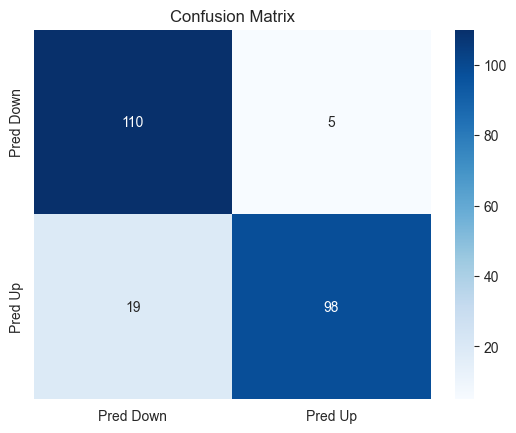

In [301]:
# -----------------------------
# 7) 학습 루프
# -----------------------------
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device) ## X.shape = (num_samples, window, input_dim)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()  ## 이전 step에서 계산된 gradient(기울기)를 모두 초기화. pytorch는 기울기를 누적하는 방식이기에 초기화 하지 않으면 이전에 쌓인 gradient가 계속 더해짐
        preds = model(X_batch) ## 모델이 처음 만들어질 때 __init__안에서 input_dim=len(features) 들어가 있음
        loss = criterion(preds, y_batch)
        loss.backward()  ## 역전파 weight, bias
        optimizer.step() ## 앞선에 구한 weight, bias를 파라미터에 적용
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - train loss: {avg_loss:.4f}")


# -----------------------------
# 8) 평가: 테스트셋 예측, 정확도, 리포트
# -----------------------------
model.eval()
preds_encoded = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        out = model(X_batch)
        pred = torch.argmax(out, dim=1).cpu()
        preds_encoded.append(pred)
preds_encoded = torch.cat(preds_encoded).numpy()   # 이 값은 0/1/2 인코딩

acc = accuracy_score(y_test, preds_encoded)
f1 = f1_score(y_test, preds_encoded, average='macro')

print(f"\n✅ Test Accuracy: {acc:.4f}")
print(f"✅ Macro F1-score: {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, preds_encoded, target_names=['Down', 'Up']))

cm = confusion_matrix(y_test, preds_encoded)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Down', 'Pred Up'], #['Pred Down', 'Pred Flat', 'Pred Up']
            yticklabels=['Pred Down', 'Pred Up'])
plt.title("Confusion Matrix")
plt.show()

In [302]:
print(df[(df.index > '2023-04-15') & (df.index < '2023-05-30')][['Close', 'mv_spread', 'trend']])

                                  Close   mv_spread trend
Date                                                     
2023-04-17 00:00:00+09:00  13205.496094  257.916518    하락
2023-04-18 00:00:00+09:00  13302.275391  247.443659    하락
2023-04-19 00:00:00+09:00  13336.147461  244.125272    하락
2023-04-20 00:00:00+09:00  13316.792969  207.384075    하락
2023-04-21 00:00:00+09:00  13326.468750  175.723326    하락
2023-04-24 00:00:00+09:00  13350.663086  181.149372    하락
2023-04-25 00:00:00+09:00  13355.502930  180.665269    하락
2023-04-26 00:00:00+09:00  13263.564453  158.233357    하락
2023-04-27 00:00:00+09:00  13234.412109  123.381864    하락
2023-04-28 00:00:00+09:00  13438.466797  106.510679    하락
2023-05-02 00:00:00+09:00  13569.645508  118.618262    하락
2023-05-03 00:00:00+09:00  13423.892578  120.406362    하락
2023-05-04 00:00:00+09:00  13171.253906   88.988246    하락
2023-05-08 00:00:00+09:00  13263.564453   66.902128    하락
2023-05-09 00:00:00+09:00  13307.289062   63.945766    하락
2023-05-10 00: